<a href="https://colab.research.google.com/github/Albertdofficial/CV/blob/main/Semantic_Segmentation_of_Road_Cracks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset as BaseDataset


In [28]:

DATA_DIR = '/content/drive/My Drive/Colab Notebooks/RoadDataset/'
x_train_dir = os.path.join(DATA_DIR, 'XTrain')
y_train_dir = os.path.join(DATA_DIR, 'yTrain')

x_valid_dir = os.path.join(DATA_DIR, 'XVal')
y_valid_dir = os.path.join(DATA_DIR, 'yVal')

x_test_dir = os.path.join(DATA_DIR, 'XTest')
y_test_dir = os.path.join(DATA_DIR, 'yTest')

path, dirs, files = next(os.walk(y_train_dir))
file_count = len(files)
print(file_count)

625


In [30]:
CLASSES = [
    "Fatigue cracking",
    "Block cracking",
    "Edge cracking",
    "Wheel path longitudinal cracking",
    "Non-wheel path longitudinal cracking",
    "Transverse cracking",
    "Patch",
    "Potholes",
    "Manholes",
    "Bumper removal",
    "Bleeding",
    "Raveling" ]


In [32]:
class Dataset(BaseDataset):
    """TrayDataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        # get images(x) and masks(y) ids
        self.ids_x = sorted(os.listdir(images_dir))
        # ['1001a01.jpg', '1005a.jpg', '1006a72.jpg', '2001a72.jpg', '2002a.jpg'] etc.
        self.ids_y = sorted(os.listdir(masks_dir))

        # get images(x) and masks(y) full paths (fps)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids_x]
        # '/content/drive/My Drive/Colab Notebooks/TrayDataset/XTest/1001a01.jpg'
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids_y]

        # convert str names to class values on masks
        # The original line was causing the error because it was converting 'cls' to lowercase
        # but the elements in 'CLASSES' have the first letter capitalized.
        # self.class_values = [CLASSES.index(cls.lower()) for cls in classes]
        # The following line fixes the issue by comparing the lowercase version of elements in 'CLASSES'
        # to the lowercase version of 'cls'
        self.class_values = [CLASSES.index(cls) for cls in classes]
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids_x)

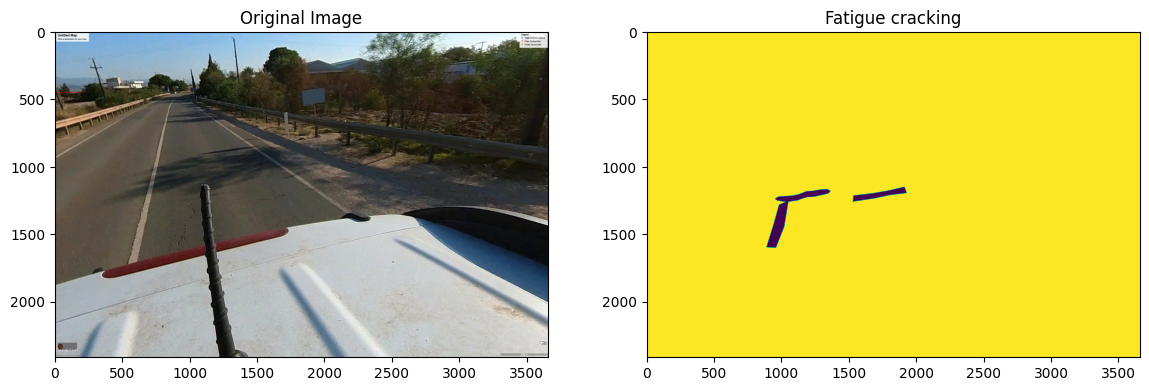

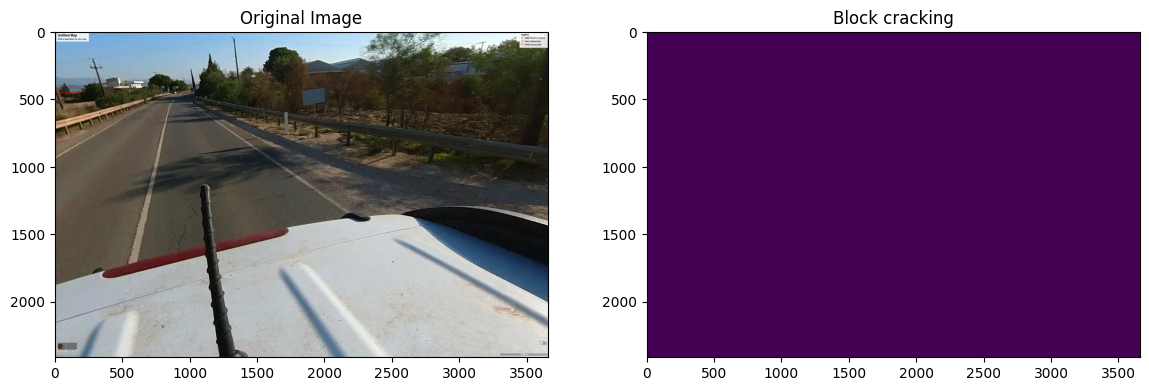

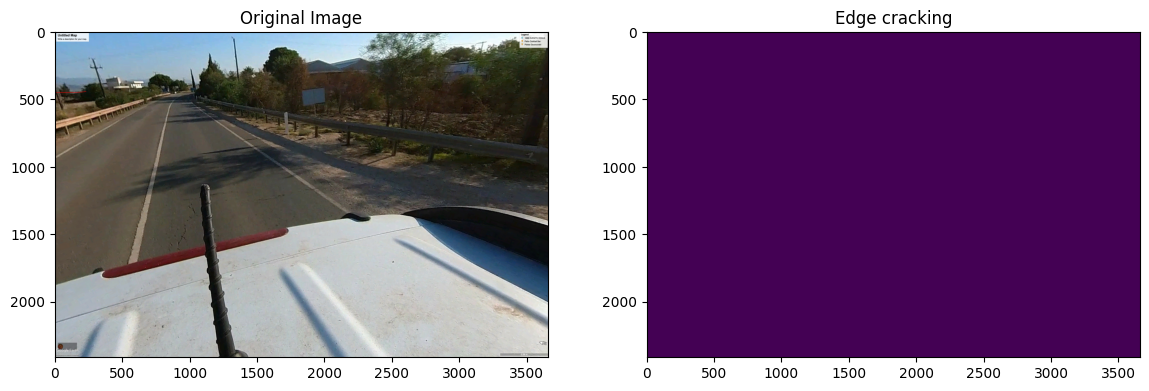

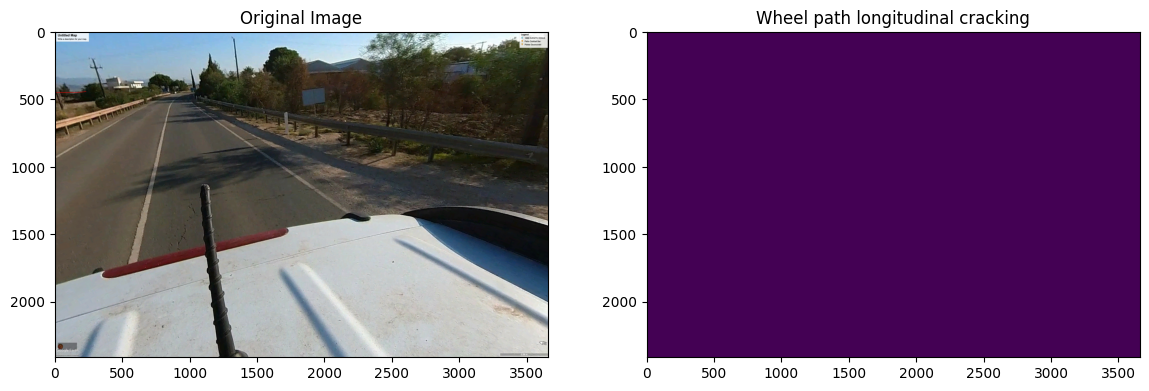

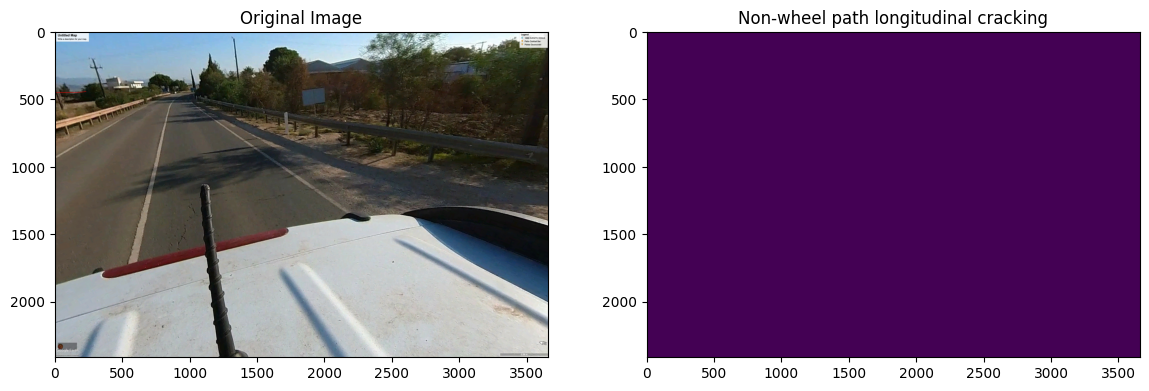

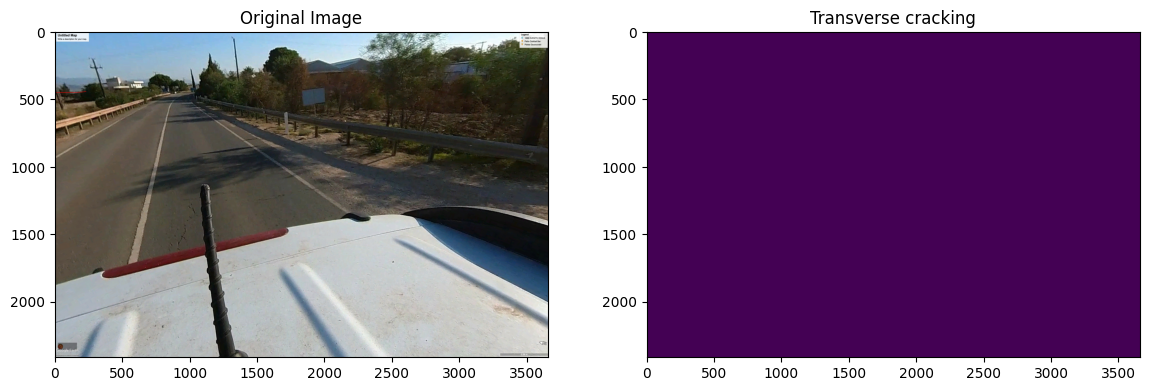

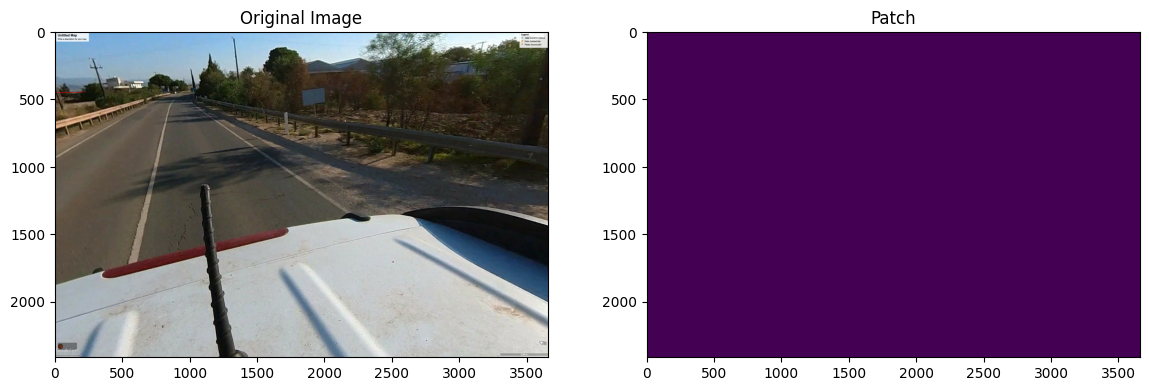

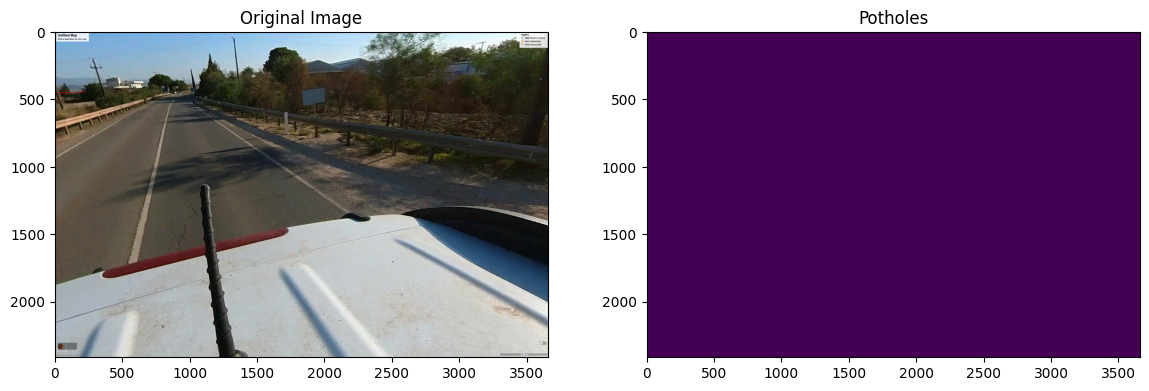

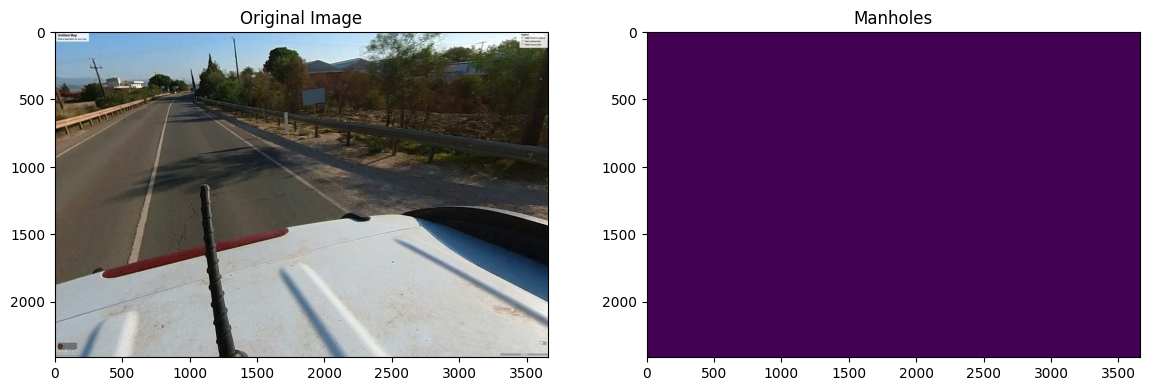

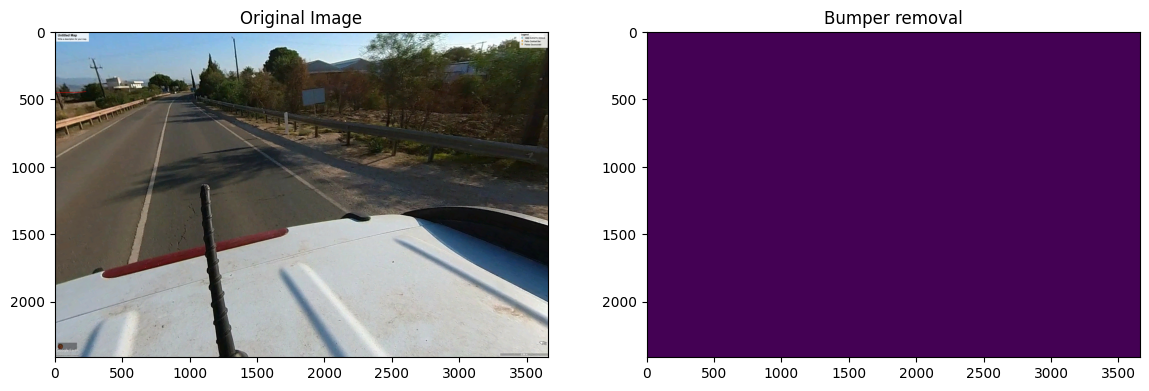

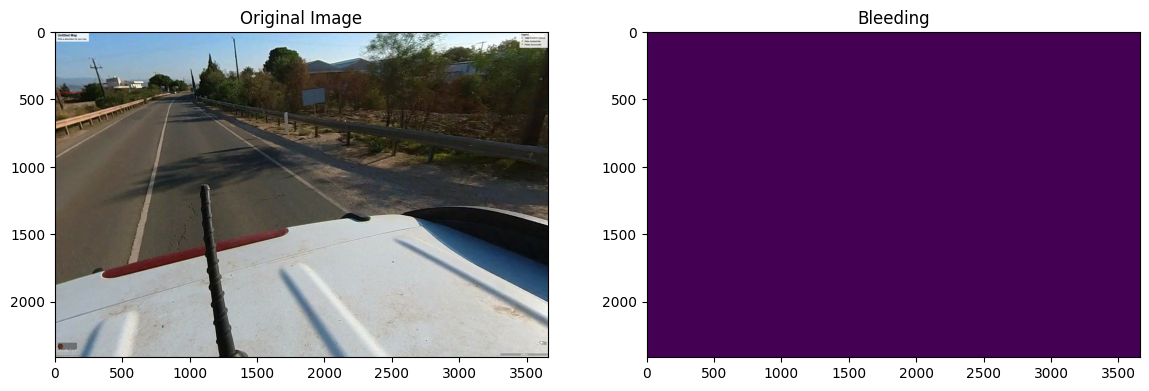

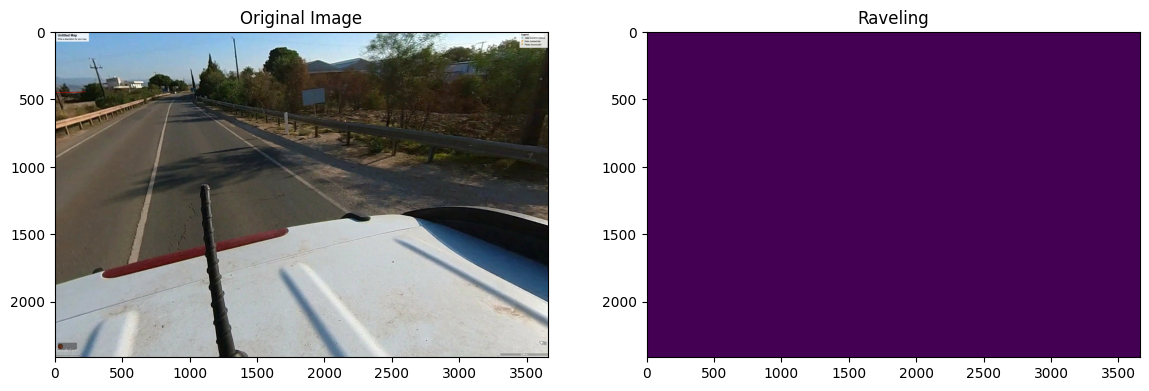

In [35]:
def visualize(image, mask, label=None, truth=None,  augment=False):
    if truth is None:
        plt.figure(figsize=(14, 20))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        if augment == False:
            plt.title(f"{'Original Image'}")
        else:
            plt.title(f"{'Mask'}")

        plt.subplot(1, 2, 2)
        plt.imshow(mask)
        if label is not None:
            plt.title(f"{label.capitalize()}")


for label  in CLASSES:
    dataset = Dataset(x_test_dir, y_test_dir, classes=[label])
    image, mask = dataset[0]
    visualize(
        image=image, mask=mask.squeeze(),
        label  = label )